In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

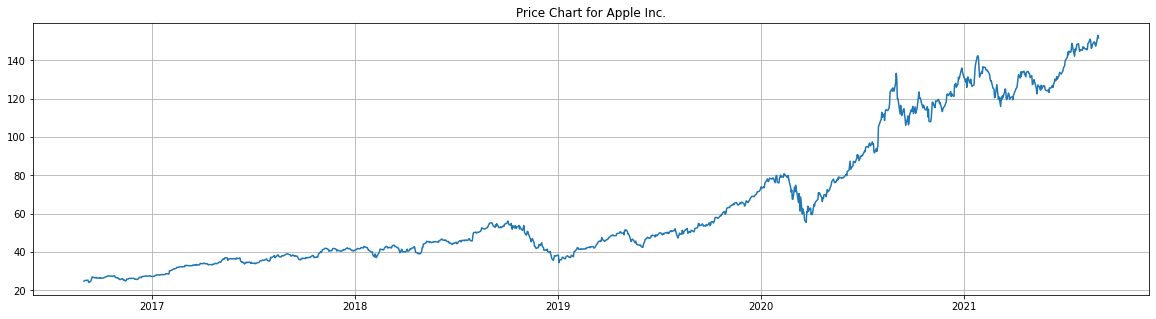

In [2]:
ticker = "AAPL"
df = yf.Ticker(ticker)
start_date = "2016-09-01"
end_date = "2021-09-01"
data = df.history(start=start_date, end=end_date)
name = df.info['shortName']
plt.figure(figsize=(20, 5))
plt.plot(data['Close'])
plt.title(f'Price Chart for {name}')
plt.grid()
plt.show()

In [3]:
def SMABacktest(ticker, short_term_sma, long_term_sma, shorts=False, start_date=start_date, end_date=end_date):
    df = yf.Ticker(ticker)
    data = df.history(start=start_date, end=end_date)
    
    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, 0)
    
    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data

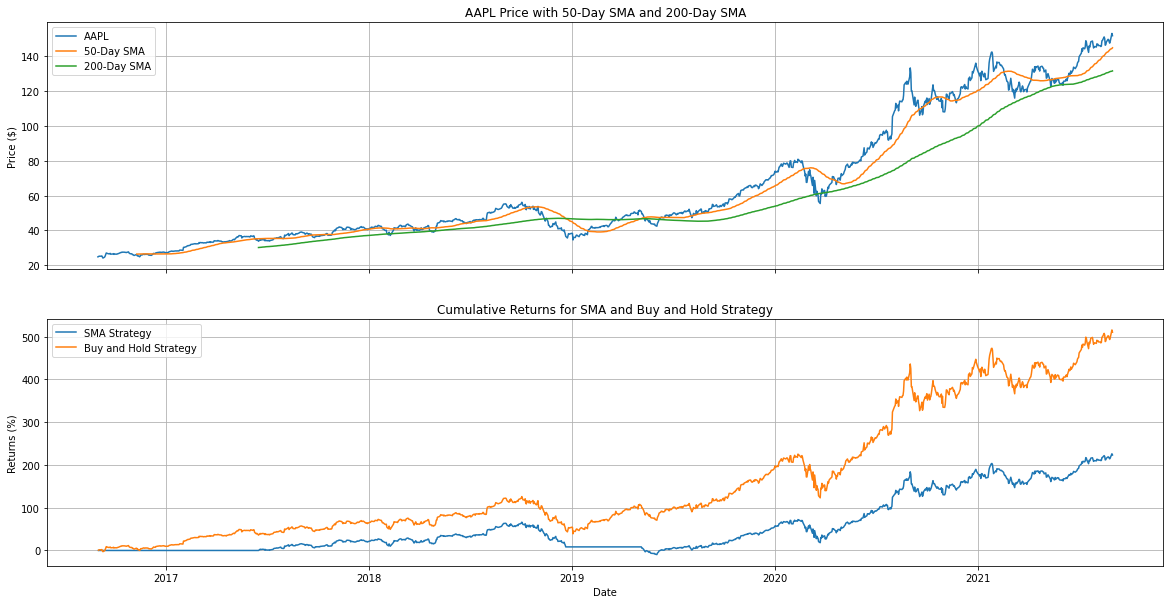

In [4]:
short_term_sma = 50
long_term_sma = 200
data = SMABacktest(ticker, short_term_sma, long_term_sma)
fig, ax = plt.subplots(2, figsize=(20, 10), sharex=True)
ax[0].plot(data['Close'], label=ticker)
ax[0].plot(data['SMA1'], label=f"{short_term_sma}-Day SMA")
ax[0].plot(data['SMA2'], label=f"{long_term_sma}-Day SMA")
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price with {short_term_sma}-Day SMA and {long_term_sma}-Day SMA')
ax[0].legend()
ax[0].grid()
ax[1].plot((data['strat_cum_returns'] - 1) * 100, label='SMA Strategy')
ax[1].plot((data['cum_returns'] - 1) * 100, label='Buy and Hold Strategy')
ax[1].set_ylabel('Returns (%)')
ax[1].set_xlabel('Date')
ax[1].set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax[1].legend()
ax[1].grid()
plt.show()

In [5]:
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    print(sma_strat['annual_volatility'])
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate) / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    strat_dd = data['strat_peak'] - data['strat_cum_returns']
    buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = strat_dd.max()
    buy_hold_strat['max_drawdown'] = buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = strat_dd[strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, (strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = buy_hold_dd[buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days, (buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat, 'base_stats': buy_hold_strat}
    
    return stats_dict

In [6]:
stats_dict = getStratStats(data, risk_free_rate=0.02)
pd.DataFrame(stats_dict).round(3)

0.28188660646975006


,strat_stats,base_stats
tot_returns,2.233,5.103
annual_returns,0.265,0.437
annual_volatility,0.282,0.303
sharpe_ratio,0.869,1.377
max_drawdown,0.758,1.092
max_drawdown_duration,467.000,372.000
